# ERROR Analysis

In [51]:
from rnn_classifier import MweRNN
import rnn_dataset
import os
import matplotlib.pyplot as plt
from mlp_classifier import MLPClassifier

In [61]:
testset      = rnn_dataset.RnnDataset("corpus/test.conllu")

token Vocab size 35693


In [2]:
mod_dir = "trained_models"
rnn_mod = "rnn_mod.pth"
toksfile= "toks.txt"
tagsfile= "tags_posbi.txt"
model, toks_vocab, tags_vocab = MweRNN.load(os.path.join(mod_dir, rnn_mod), "RNN",
                                                                   os.path.join(mod_dir, toksfile),
                                                                   os.path.join(mod_dir, tagsfile), embsize=64, hidden_size=64, drop_out=0.1, device="cpu")

model.to("cpu")
model.eval()

MweRNN(
  (word_embedding): Embedding(35693, 64)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (crf): CRF(
    (fc): Linear(in_features=64, out_features=30, bias=True)
  )
  (rnn): RNN(64, 32, batch_first=True, bidirectional=True)
)

In [5]:
class_counts, TP, FP, FN, average_precision, average_recall, average_f1_score, weighted_f1_score, weighted_recall, weighted_precision = model.evaluate(testset.get_loader(batch_size = 500))

100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.13s/it]


In [21]:
precision = TP/(FP+TP)
recall    = TP/(FN+TP)
f_score   = 2*(precision*recall)/(precision+recall)

In [36]:
print("tags-------class count --------recall----------precision---------f-score")
for tag in range(len(model.tags_vocab)):
    print(f"{model.tags_vocab.rev_lookup(tag)} %d   | Precision %.4f | Recall  %.4f |  F-score  %.4f   " % (int(class_counts[tag]), float(recall[tag]), float(precision[tag]), float(f_score[tag])))
    print()
print(f"weighted Precision %.4f | Recall  %.4f |  F-score  %.4f   " % (weighted_f1_score, weighted_recall, weighted_precision))

tags-------class count --------recall----------precision---------f-score
<unk> 0   | Precision nan | Recall  nan |  F-score  nan   

<pad> 0   | Precision nan | Recall  nan |  F-score  nan   

B_CL 3193   | Precision 0.9411 | Recall  0.9190 |  F-score  0.9299   

I_V 0   | Precision nan | Recall  0.0000 |  F-score  nan   

I_ADV 0   | Precision nan | Recall  nan |  F-score  nan   

B_V 19199   | Precision 0.9370 | Recall  0.8107 |  F-score  0.8693   

B_P 35723   | Precision 0.9702 | Recall  0.9027 |  F-score  0.9353   

B_A 5812   | Precision 0.7213 | Recall  0.8351 |  F-score  0.7740   

B_D 29791   | Precision 0.9073 | Recall  0.9668 |  F-score  0.9361   

B_N 76943   | Precision 0.9199 | Recall  0.8899 |  F-score  0.9047   

B_PONCT 16084   | Precision 1.0000 | Recall  0.9664 |  F-score  0.9829   

B_C 2258   | Precision 0.9601 | Recall  0.9079 |  F-score  0.9333   

B__ 1747   | Precision 0.9994 | Recall  0.9994 |  F-score  0.9994   

B_ADV 2205   | Precision 0.8204 | Recall  0.78

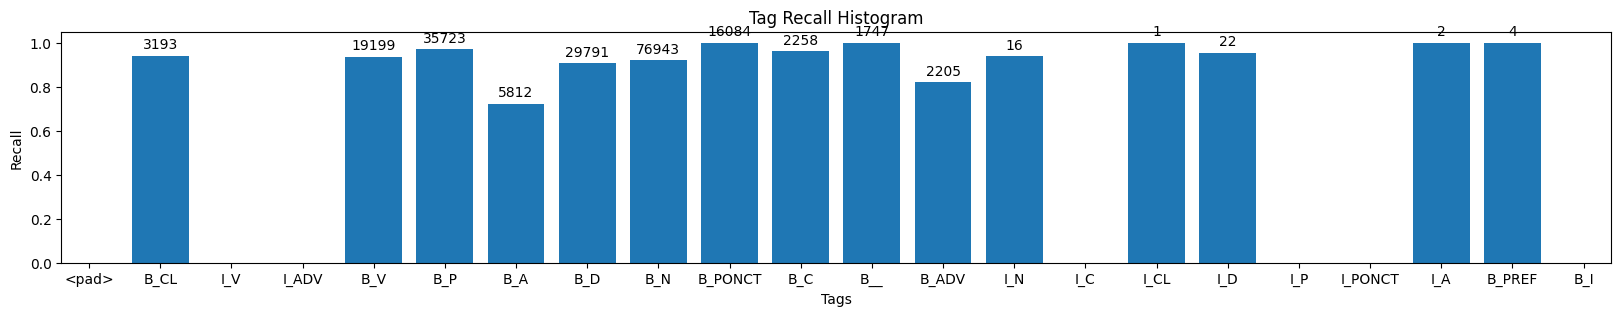

In [42]:

tags = [model.tags_vocab.rev_lookup(tag) for tag in range(len(model.tags_vocab))]

fig, ax = plt.subplots(figsize=(20, 3))  

# Plot the histogram
bars = ax.bar(tags, recall)

# Add class count annotations on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = int(class_counts[i])
    ax.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

# Set axis labels and title
ax.set_xlabel('Tags')
ax.set_ylabel('Recall')
ax.set_title('Tag Recall Histogram')

# Display the plot
plt.show()

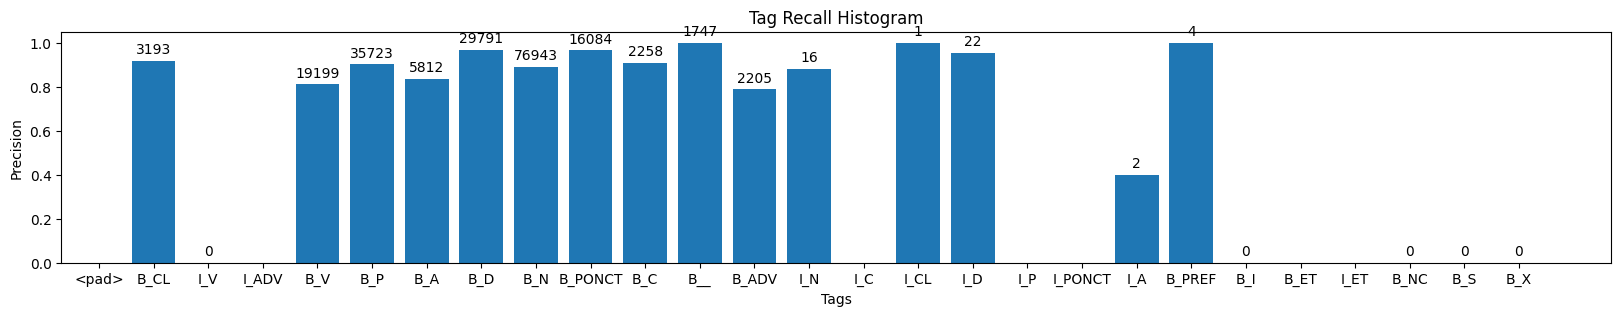

In [41]:
tags = [model.tags_vocab.rev_lookup(tag) for tag in range(len(model.tags_vocab))]

fig, ax = plt.subplots(figsize=(20, 3))  

# Plot the histogram
bars = ax.bar(tags, precision)

# Add class count annotations on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = int(class_counts[i])
    ax.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

# Set axis labels and title
ax.set_xlabel('Tags')
ax.set_ylabel('Precision')
ax.set_title('Tag Recall Histogram')

# Display the plot
plt.show()

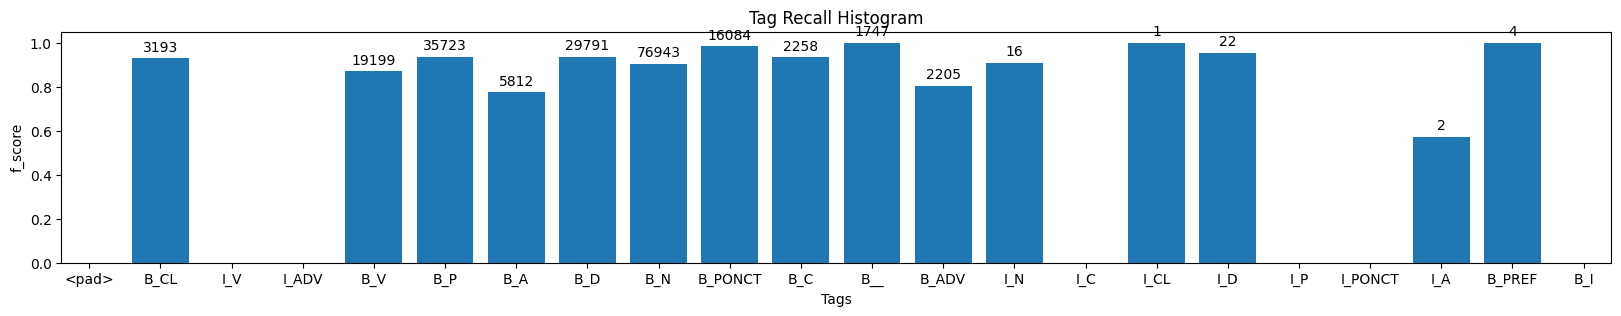

In [38]:
tags = [model.tags_vocab.rev_lookup(tag) for tag in range(len(model.tags_vocab))]

fig, ax = plt.subplots(figsize=(20, 3))  

# Plot the histogram
bars = ax.bar(tags, f_score)

# Add class count annotations on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = int(class_counts[i])
    ax.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

# Set axis labels and title
ax.set_xlabel('Tags')
ax.set_ylabel('f_score')
ax.set_title('Tag Recall Histogram')

# Display the plot
plt.show()

In [52]:
mod_dir = "trained_models"
rnn_mod = "mlp_mod.pth"
toksfile= "toks.txt"
tagsfile= "tags_posbi.txt"
modelmlp, toks_vocab, tags_vocab = MLPClassifier.load(os.path.join(mod_dir, rnn_mod),
                                                                   os.path.join(mod_dir, toksfile),
                                                                   os.path.join(mod_dir, tagsfile), window_size =6, embsize=64, hidden_size=64, drop_out=0.1, device="cpu")

modelmlp.to("cpu")
modelmlp.eval()

MLPClassifier(
  (word_embedding): Embedding(35693, 64)
  (FFW): Linear(in_features=64, out_features=28, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
  (net): MLP_baseline(
    (net): Sequential(
      (0): Linear(in_features=832, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): ReLU()
    )
  )
)

In [53]:
testset      = rnn_dataset.RnnDataset("corpus/test.conllu")

token Vocab size 35693


In [54]:
class_counts, TP, FP, FN, average_precision, average_recall, average_f1_score, weighted_f1_score, weighted_recall, weighted_precision = model.evaluate(testset.get_loader(batch_size = 500))

100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.43s/it]


In [56]:
precision = TP/(FP+TP)
recall    = TP/(FN+TP)
f_score   = 2*(precision*recall)/(precision+recall)

In [57]:
print("tags-------class count --------recall----------precision---------f-score")
for tag in range(len(model.tags_vocab)):
    print(f"{model.tags_vocab.rev_lookup(tag)} %d   | Precision %.4f | Recall  %.4f |  F-score  %.4f   " % (int(class_counts[tag]), float(recall[tag]), float(precision[tag]), float(f_score[tag])))
    print()
print(f"weighted Precision %.4f | Recall  %.4f |  F-score  %.4f   " % (weighted_f1_score, weighted_recall, weighted_precision))

tags-------class count --------recall----------precision---------f-score
<unk> 0   | Precision nan | Recall  nan |  F-score  nan   

<pad> 0   | Precision nan | Recall  nan |  F-score  nan   

B_CL 3193   | Precision 0.9411 | Recall  0.9190 |  F-score  0.9299   

I_V 0   | Precision nan | Recall  0.0000 |  F-score  nan   

I_ADV 0   | Precision nan | Recall  nan |  F-score  nan   

B_V 19199   | Precision 0.9370 | Recall  0.8107 |  F-score  0.8693   

B_P 35723   | Precision 0.9702 | Recall  0.9027 |  F-score  0.9353   

B_A 5812   | Precision 0.7213 | Recall  0.8351 |  F-score  0.7740   

B_D 29791   | Precision 0.9073 | Recall  0.9668 |  F-score  0.9361   

B_N 76943   | Precision 0.9199 | Recall  0.8899 |  F-score  0.9047   

B_PONCT 16084   | Precision 1.0000 | Recall  0.9664 |  F-score  0.9829   

B_C 2258   | Precision 0.9601 | Recall  0.9079 |  F-score  0.9333   

B__ 1747   | Precision 0.9994 | Recall  0.9994 |  F-score  0.9994   

B_ADV 2205   | Precision 0.8204 | Recall  0.78

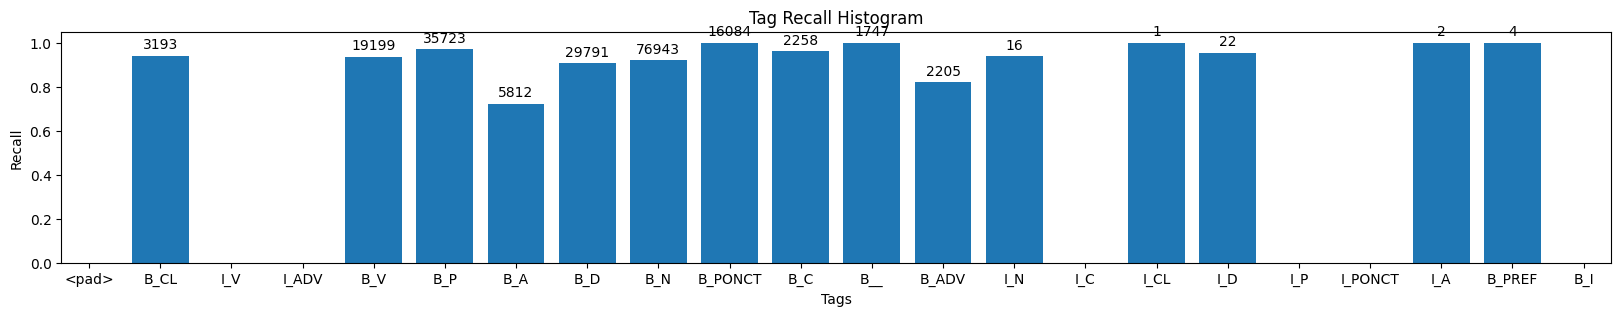

In [58]:
tags = [model.tags_vocab.rev_lookup(tag) for tag in range(len(model.tags_vocab))]

fig, ax = plt.subplots(figsize=(20, 3))  

# Plot the histogram
bars = ax.bar(tags, recall)

# Add class count annotations on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = int(class_counts[i])
    ax.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

# Set axis labels and title
ax.set_xlabel('Tags')
ax.set_ylabel('Recall')
ax.set_title('Tag Recall Histogram')

# Display the plot
plt.show()

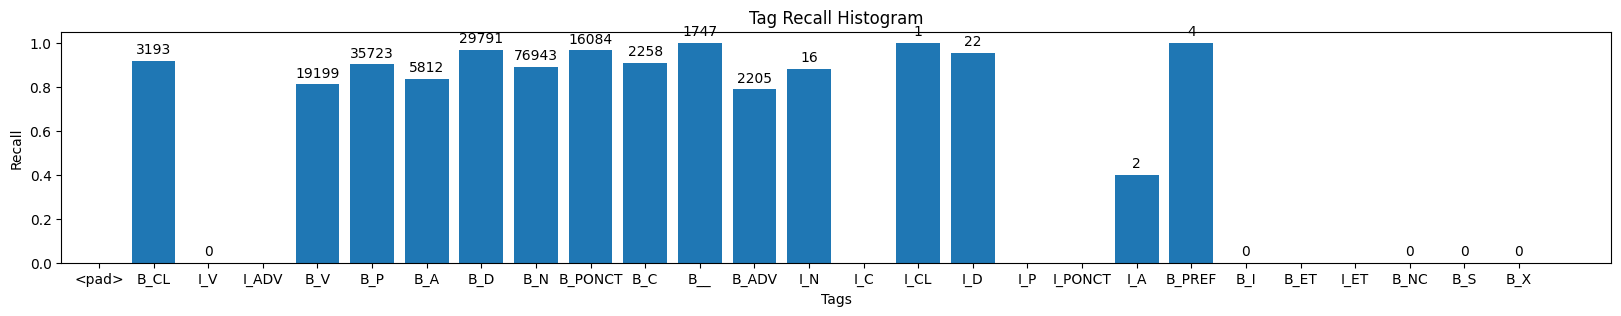

In [59]:
tags = [model.tags_vocab.rev_lookup(tag) for tag in range(len(model.tags_vocab))]

fig, ax = plt.subplots(figsize=(20, 3))  

# Plot the histogram
bars = ax.bar(tags, precision)

# Add class count annotations on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = int(class_counts[i])
    ax.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

# Set axis labels and title
ax.set_xlabel('Tags')
ax.set_ylabel('Recall')
ax.set_title('Tag Recall Histogram')

# Display the plot
plt.show()

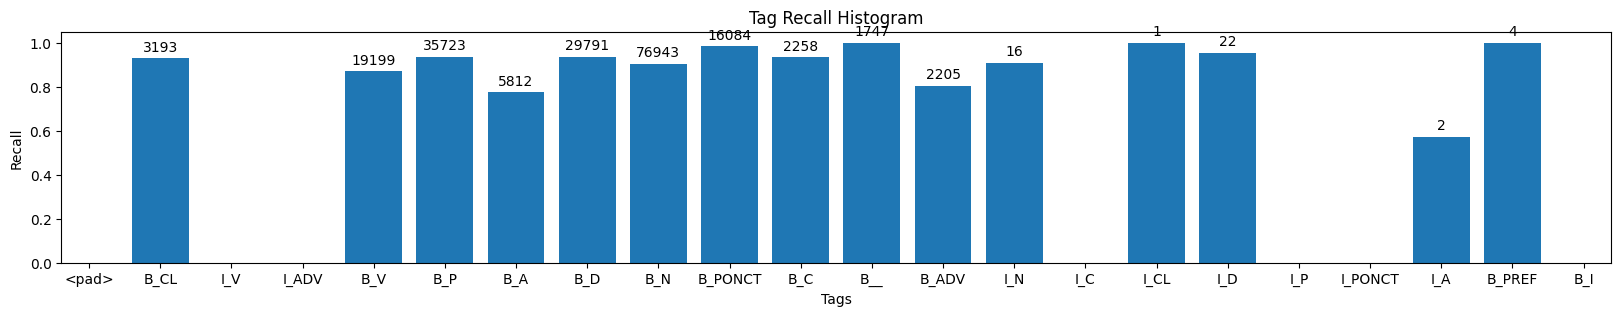

In [60]:
tags = [model.tags_vocab.rev_lookup(tag) for tag in range(len(model.tags_vocab))]

fig, ax = plt.subplots(figsize=(20, 3))  

# Plot the histogram
bars = ax.bar(tags, f_score)

# Add class count annotations on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = int(class_counts[i])
    ax.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

# Set axis labels and title
ax.set_xlabel('Tags')
ax.set_ylabel('Recall')
ax.set_title('Tag Recall Histogram')

# Display the plot
plt.show()

In [ ]:
mod_dir = "trained_models"
rnn_mod = "rnn_mod.pth"
toksfile= "toks.txt"
tagsfile= "tags_posbi.txt"
model, toks_vocab, tags_vocab = MweRNN.load(os.path.join(mod_dir, rnn_mod), "RNN",
                                                                   os.path.join(mod_dir, toksfile),
                                                                   os.path.join(mod_dir, tagsfile), embsize=64, hidden_size=64, drop_out=0.1, device="cpu")

model.to("cpu")
model.eval()